# IronHacks Submission Notebook

## Background
---

Write a brief summary about goal of this notebook and provide some insight to the reader about how read through your document.

## Setup
---

In [569]:
%%capture
%logstop
%logstart -t -r -q ipython_command_log.py global

#- IRONHACKS RESEARCH TRACKING CODE
#----------------------------------
# The following code is used to help our research team understand how you 
# our notebook environment. We do not collect any personal information with
# the following code, it is used to measure when and how often you work on
# your submission files.

import os
from datetime import datetime
import IPython.core.history as history

ha = history.HistoryAccessor()
ha_tail = ha.get_tail(1)
ha_cmd = next(ha_tail)
session_id = str(ha_cmd[0])
command_id = str(ha_cmd[1])
timestamp = datetime.utcnow().isoformat()
history_line = ','.join([session_id, command_id, timestamp]) + '\n'
logfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')
logfile.write(history_line)
logfile.close()

In [6]:
%%capture

#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED
#------------------------------------------
# This is normally not required. The hub environment comes preinstaled with 
# many packages that you can already use without setup. In case there is some
# other library you would like to use that isn't on the list you run this command
# once to install them.  If it is already installed this command has no effect.

!python3 -m pip install google.cloud
!python3 -m pip install numpy
!python3 -m pip install pyarrow
!python3 -m pip install pandas

### Imports

In [285]:
#- IMPORT THE LIBRARIES YOU WILL USE
#------------------------------------------
# You only need to import packages one time per notebook session. To keep your
# notebook clean and organized you can handle all imports at the top of your file.
# The following are included for example purposed, feel free to modify or delete 
# anything in this section.

import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import pyarrow
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt

In [8]:
# CONFIGURE THE BIGQUERY SETTINGS

BIGQUERY_PROJECT = 'ironhacks-covid19-data'
BIGQUERY_KEYPATH = 'service-account.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

## Classes and Functions
---

In [9]:
#- DEFINE YOUR CLASSES AND FUNCTIONS 
#-----------------------------------
# This is not required, but is helpful in keeping your notebook organized. 
# You can use the following cell or several cells to define your functions
# and classes to keep them separate from your analysis or results code.
# In general it useful to define your methods in a separate cell from where
# it is run.

def example_function():
    print('Hello World')

In [10]:
def get_weekly_pattern():
    query = """
        SELECT poi_id, week_number, raw_visit_counts, date_start, poi_cbg
        FROM ironhacks_covid19_competition.weekly_patterns
        """
    query_job = bigquery_client.query(query)
    wp = query_job.to_dataframe()
    return wp

In [99]:
def get_social_distance():
    query = """
        SELECT *
        FROM ironhacks_covid19_competition.cbg_social_distancing
        """
    query_job = bigquery_client.query(query)
    sd = query_job.to_dataframe()
    filtered = sd.loc[sd['cbg'].isin(unique)]
    filtered = filtered.drop_duplicates()
    return filtered

In [27]:
def get_sd():
    return pd.read_csv("social_distance.csv")

In [169]:
def get_covid():
    covid = pd.read_csv("weekly new covid cases.csv")
    covid['week'] = range(11,44)
    return covid

In [499]:
def merge(wp, sd, covid):
    
    merge = wp.merge(covid, left_on='week_number', right_on='week', how = 'right')
    merge = merge.sort_values('week').fillna(method='ffill')
    merge = merge.merge(sd, left_on=['poi_cbg','week'], right_on=['cbg','week_number'])
#     del merge['week_number']
    del merge['date_start']
    del merge['poi_cbg']
    del merge['cbg']
    del merge['week_number_y']
    del merge['week_number_x']
    del merge['poi_id']
    merge.index = pd.DatetimeIndex(merge['Date'])
    del merge['Date']
    del merge['week']

    merge.columns = ['raw_visit_counts', 'covid_cases', 'device_count', 'completly_home', 'median_home', 'non_home']
#     del merge['completly_home']
#     del merge['median_home']
#     del merge['non_home']
#     del merge['device_count']
    return merge

In [138]:
def get_data(poi_id, df):
    df = df.loc[df['poi_id'] == poi_id]
    return df

In [235]:

def grangers_causation_matrix(data, variables= df.columns, verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
    maxlag=9
    test = 'ssr_chi2test'
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [67]:
def var(df):
#     data = np.log(df).diff().dropna()
    model = VAR(df)
    return model

In [242]:
def cointegration_test(df, alpha=0.05): 
#     """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [258]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [275]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

## Analysis
---

In [13]:
example_function()

Hello World


In [172]:
sd = get_sd()
wp = get_weekly_pattern()
covid = get_covid()
wp['date_start'] = pd.DatetimeIndex(wp['date_start'])
covid['Date'] = pd.DatetimeIndex(covid["Date"])

In [557]:
curr_id = uniq_id[94]
df = get_data(curr_id, wp)
merg = merge(df, sd, covid)
merg

,raw_visit_counts,covid_cases,device_count,completly_home,median_home,non_home
Date,,,,,,
2020-03-16,3.0,0.0,984,300,5262,644
2020-03-23,6.0,2.0,970,389,6599,183
2020-03-30,4.0,12.0,1014,404,7046,131
2020-04-06,8.0,20.0,1033,442,7256,123
2020-04-13,11.0,11.0,833,338,7338,214
2020-04-20,3.0,13.0,966,366,7065,233
2020-04-27,7.0,32.0,969,322,6451,265
2020-05-04,7.0,92.0,1000,356,6874,303
2020-05-11,7.0,63.0,1035,332,6199,399


In [558]:
grangers_causation_matrix(merg, merg.columns)

,raw_visit_counts_x,covid_cases_x,device_count_x,completly_home_x,median_home_x,non_home_x
raw_visit_counts_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
covid_cases_y,0.0001,1.0000,0.0001,0.1496,0.0000,0.0000
device_count_y,0.0000,0.4091,1.0000,0.0005,0.0007,0.0315
completly_home_y,0.0003,0.0016,0.0000,1.0000,0.0000,0.0037
median_home_y,0.0001,0.0069,0.0000,0.0351,1.0000,0.0017
non_home_y,0.0000,0.0000,0.2828,0.3372,0.0132,1.0000


In [559]:
cointegration_test(merg)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
raw_visit_counts ::  187.88    > 83.9383   =>   True
covid_cases ::  67.68     > 60.0627   =>   True
device_count ::  32.8      > 40.1749   =>   False
completly_home ::  11.76     > 24.2761   =>   False
median_home ::  0.99      > 12.3212   =>   False
non_home ::  0.29      > 4.1296    =>   False


In [560]:
nobs = 4
df_train, df_test = merg.iloc[0:-nobs], merg.iloc[-nobs:]
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "raw_visit_counts" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4845
 No. Lags Chosen       = 1
 Critical value 1%     = -3.7
 Critical value 5%     = -2.976
 Critical value 10%    = -2.628
 => P-Value = 0.0084. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "covid_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.8745
 No. Lags Chosen       = 1
 Critical value 1%     = -3.7
 Critical value 5%     = -2.976
 Critical value 10%    = -2.628
 => P-Value = 0.9985. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "device_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [561]:
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "raw_visit_counts" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1564
 No. Lags Chosen       = 8
 Critical value 1%     = -3.833
 Critical value 5%     = -3.031
 Critical value 10%    = -2.656
 => P-Value = 0.2224. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "covid_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1014
 No. Lags Chosen       = 0
 Critical value 1%     = -3.7
 Critical value 5%     = -2.976
 Critical value 10%    = -2.628
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "device_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [562]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  52.661969897901
BIC :  54.67771613390774
FPE :  7.986528999401776e+22
HQIC:  53.26135692634263 

Lag Order = 2
AIC :  52.89947709827361
BIC :  56.67376671233805
FPE :  1.7018122138384248e+23
HQIC:  53.98633594313035 

Lag Order = 3
AIC :  50.98468377180754
BIC :  56.54275753320653
FPE :  2.362706115144356e+23
HQIC:  52.52625721589749 

Lag Order = 4
AIC :  -312.5400086993509
BIC :  -305.17717225967624
FPE :  9.508112337958897e-132
HQIC:  -310.58664611926906 

Lag Order = 5
AIC :  -319.77575643022715
BIC :  -310.5930640753218
FPE :  1.1877772077169633e-141
HQIC:  -317.4663350414595 

Lag Order = 6
AIC :  -320.27896751674933
BIC :  -309.26935730558813
FPE :  5.1088597703045395e-145
HQIC:  -317.68543440232133 

Lag Order = 7
AIC :  -318.282502740254
BIC :  -305.44979850536623
FPE :  7.63788810142312e-147
HQIC:  -315.49747741438006 

Lag Order = 8
AIC :  -316.4972276039341
BIC :  -301.8599631826904
FPE :  1.0900572380658772e-148
HQIC:  -313.6398798132046 



/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


In [563]:
model_fitted = model.fit(4)
# model_fitted.summary()

In [564]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(merg.columns, out):
    print(col, ':', round(val, 2))

raw_visit_counts : 1.72
covid_cases : 2.44
device_count : 1.47
completly_home : 1.43
median_home : 1.39
non_home : 1.77


In [565]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[  -1.,   51.,  -42.,   78.,  866.,  -58.],
       [   7.,   72.,  -46.,  -46., -744.,  -92.],
       [  -6.,   -8.,   20.,   66.,  386., -112.],
       [  -1.,   98.,   98.,  -24., -184.,  226.]])

In [566]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=merg.index[-nobs:], columns=merg.columns + '_1d')
df_forecast

,raw_visit_counts_1d,covid_cases_1d,device_count_1d,completly_home_1d,median_home_1d,non_home_1d
Date,,,,,,
2020-10-05,-1.667284,102.575606,-314.625133,-122.045311,-1250.609804,663.577166
2020-10-12,-2.377295,230.465765,160.739621,22.731536,3633.260206,732.370301
2020-10-19,4.132536,159.947011,-927.257429,-303.295647,-2168.629945,1660.070883
2020-10-26,5.065689,229.157802,-986.228230,-475.911795,-1853.247149,1496.435256


In [567]:
df_results = invert_transformation(df_train, df_forecast)
df_results.loc[:, ['raw_visit_counts_forecast', 'covid_cases_forecast', 'device_count_forecast' , 'completly_home_forecast','median_home_forecast', 'non_home_forecast']]

,raw_visit_counts_forecast,covid_cases_forecast,device_count_forecast,completly_home_forecast,median_home_forecast,non_home_forecast
Date,,,,,,
2020-10-05,6.332716,435.575606,1723.374867,293.954689,9437.390196,3817.577166
2020-10-12,3.955421,666.041371,1884.114488,316.686225,13070.650402,4549.947466
2020-10-19,8.087957,825.988382,956.857059,13.390578,10902.020457,6210.018349
2020-10-26,13.153646,1055.146184,-29.371172,-462.521217,9048.773308,7706.453605


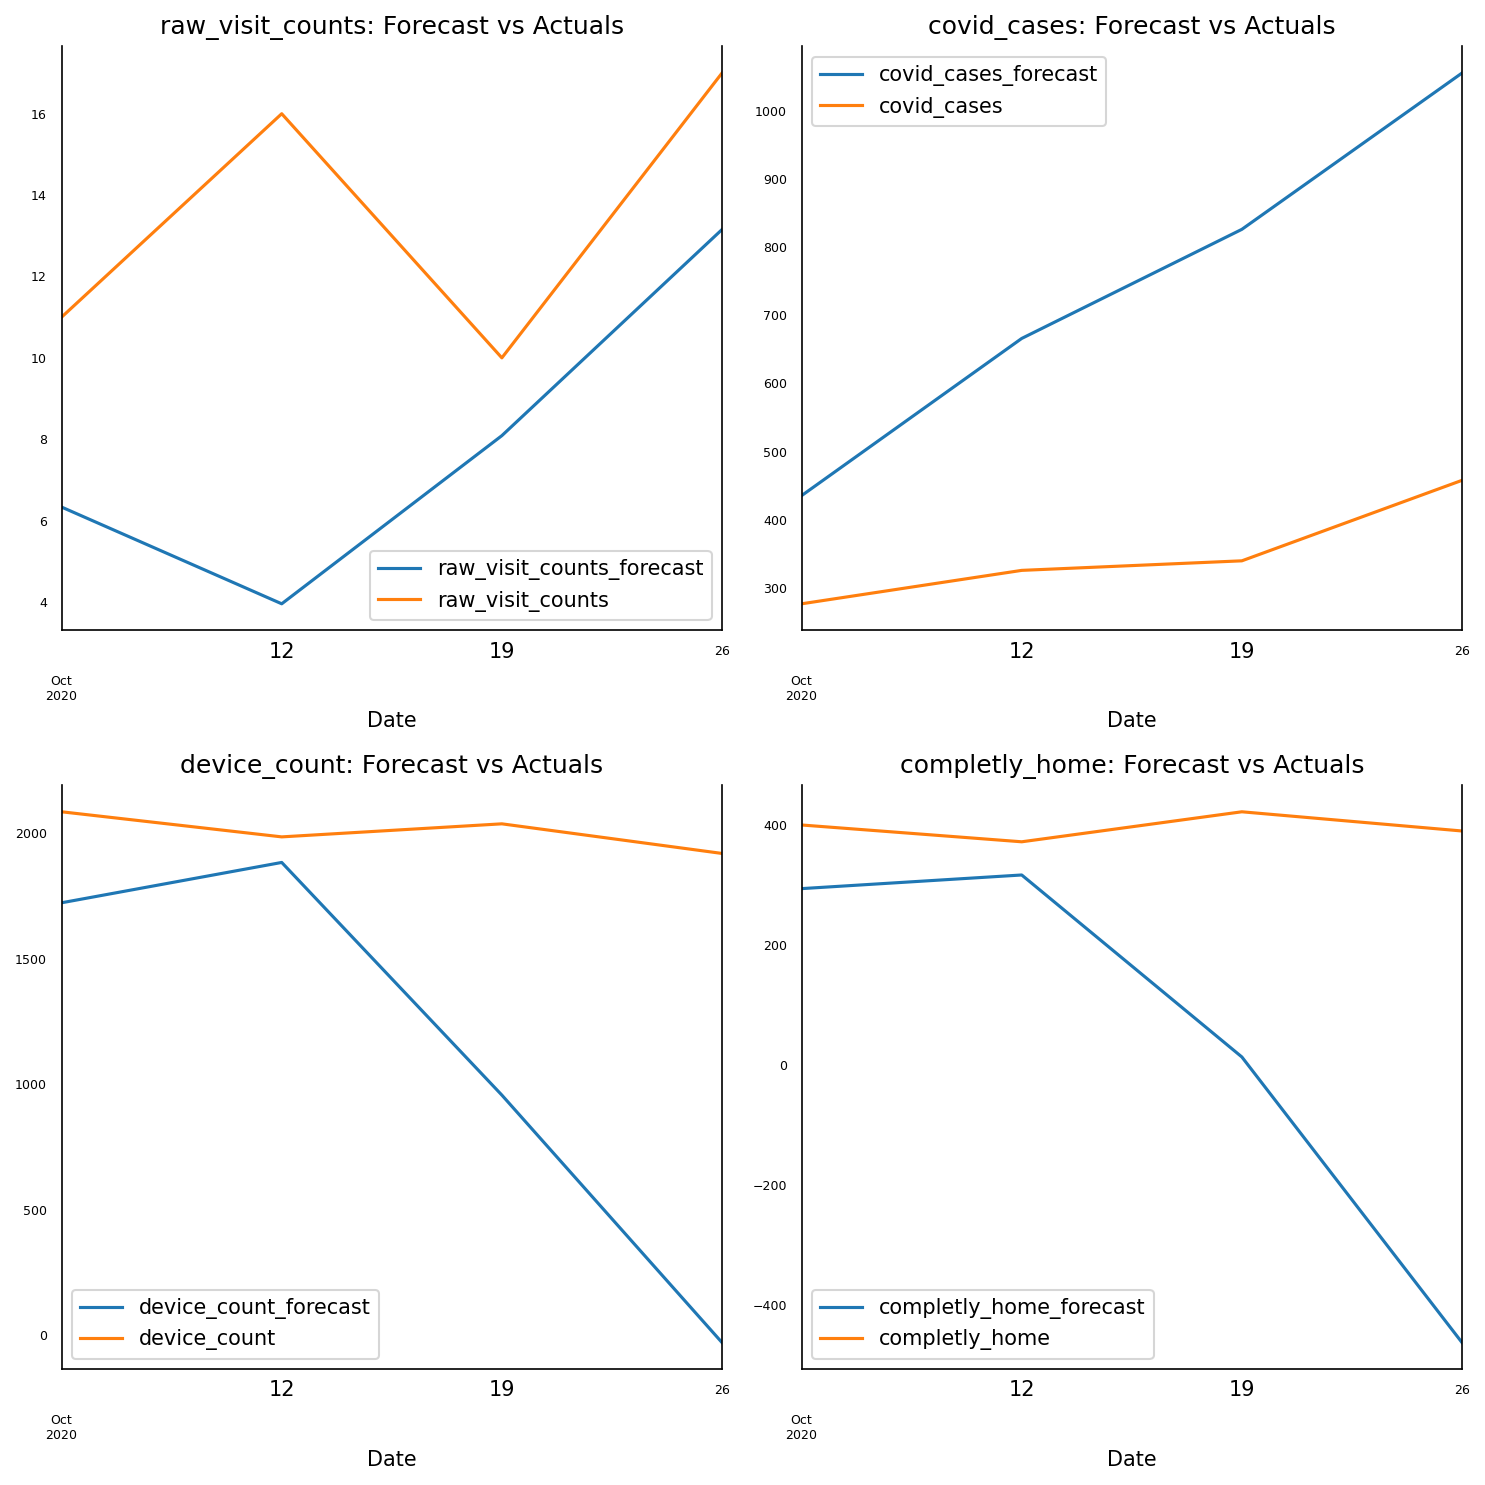

In [568]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(merg.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Results
---

This section may not be necessary for you individual notebook, but if you've created nice charts or tables you can present them together with some explanation in section. In addition if you have any comments or thoughts about what you would like to do or items that are still in progress you can summarize them at the bottom of the page.

In [ ]:
## This can also be a good place for you to cleanup any input/output and export your results to a file.